In [1]:
# Framework imports
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import pandas as pd
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import ZeroPadding1D
from keras.layers import UpSampling1D
from keras.layers import Input
import os
from keras_preprocessing.image import ImageDataGenerator
from matplotlib import image
from matplotlib import pyplot
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()
os.chdir('/content/drive/MyDrive/MLMA_project/Segmented_Images')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df1 =pd.read_csv('/content/drive/MyDrive/MLMA_project/train.csv')
df2 = pd.read_csv('/content/drive/MyDrive/MLMA_project/test.csv')
df= pd.concat([df1,df2],axis=0)
df.nunique()
df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker


In [4]:
# Function for fetching ids of patient and image arrays 3d (i.e 3 slices per person) of each patient 
def get_lists_pid_imgs(word):
  list_of_ids= os.listdir('/content/drive/MyDrive/MLMA_project/Segmented_Images/'+word)
  my_list_of_arrays=[]
  ids_list= []
  for j in list_of_ids:
    my_list_imgs= os.listdir('/content/drive/MyDrive/MLMA_project/Segmented_Images/'+word+'/'+j)
    v= len(my_list_imgs)//3
    n=v//2
    my_new_list= [n,v+n,v+v+n]
    image_list=[]
    for k in my_new_list:
      image = Image.open('/content/drive/MyDrive/MLMA_project/Segmented_Images/'+word+'/'+j+'/'+my_list_imgs[k])
      np_image= np.array(image)
      image_list.append(np_image)
    stacked_array= np.dstack((image_list[0],image_list[1],image_list[2]))
    my_list_of_arrays.append(stacked_array) 
    ids_list.append(j)
  return (np.array(ids_list),np.array(my_list_of_arrays))

In [5]:
# Function for fetching the percent values for each patientid
def percent_label(my_ids,df):
  my_df= df.groupby(by='Patient').mean()
  my_df.reset_index(inplace=True)
  my_percent_list= []
  for i in my_ids:
    ab= my_df.loc[my_df['Patient'] == i]['Percent']
    my_percent_list.append(ab.tolist()[0])
  return np.array(my_percent_list)

In [6]:
my_ids_train,my_imgarray_train= get_lists_pid_imgs('train')
percent_list_train = percent_label(my_ids_train,df)

In [7]:
my_ids_test,my_imgarray_test= get_lists_pid_imgs('test')
percent_list_test = percent_label(my_ids_test,df)

In [8]:
my_ids_val,my_imgarray_val= get_lists_pid_imgs('val')
percent_list_val = percent_label(my_ids_val,df)

In [9]:
inputs = keras.Input(shape=(512,512,3))
C1=Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(512,512,3))(inputs)
M1=MaxPooling2D((2, 2))(C1)
C2=Conv2D(64, (3, 3), activation='relu',padding='same')(M1)
M2=MaxPooling2D((2, 2))(C2)
F=Flatten()(M2)
D1=Dense(100, activation='relu')(F)
outputs=Dense(1, activation='linear')(D1)
model_Built=keras.Model(inputs,outputs)

In [10]:
model_Built.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1048576)           0     

In [11]:
model_Built.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae', metrics=['mae']) 

In [12]:
history=model_Built.fit(my_imgarray_train, percent_list_train, epochs=20, batch_size= 10, validation_data= (my_imgarray_val,percent_list_val))

Epoch 1/20
15/15 [==============================] - 8s 152ms/step - loss: 11889.3213 - mae: 11889.3213 - val_loss: 50.1545 - val_mae: 50.1545
Epoch 2/20
15/15 [==============================] - 1s 97ms/step - loss: 30.3944 - mae: 30.3944 - val_loss: 18.5612 - val_mae: 18.5612
Epoch 3/20
15/15 [==============================] - 1s 99ms/step - loss: 14.4993 - mae: 14.4993 - val_loss: 13.0820 - val_mae: 13.0820
Epoch 4/20
15/15 [==============================] - 1s 96ms/step - loss: 14.5314 - mae: 14.5314 - val_loss: 15.2711 - val_mae: 15.2711
Epoch 5/20
15/15 [==============================] - 1s 85ms/step - loss: 14.9207 - mae: 14.9207 - val_loss: 12.2882 - val_mae: 12.2882
Epoch 6/20
15/15 [==============================] - 1s 87ms/step - loss: 13.7763 - mae: 13.7763 - val_loss: 12.4608 - val_mae: 12.4608
Epoch 7/20
15/15 [==============================] - 1s 84ms/step - loss: 9.8790 - mae: 9.8790 - val_loss: 11.0301 - val_mae: 11.0301
Epoch 8/20
15/15 [==============================] 

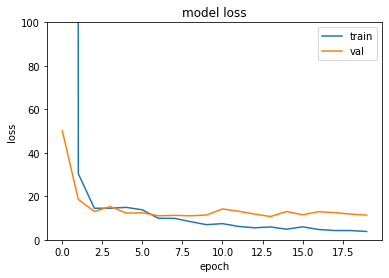

In [13]:
# Plotting the training and validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.ylim(top=100)
plt.ylim(bottom=0)
plt.show()

In [14]:
image=my_imgarray_test[2]
print(image.shape)
layer_of_interest=-2 # penultimate layer - dense 64 layer
intermediate_tensor_function= K.function([model_Built.input],[model_Built.layers[layer_of_interest].output])

(512, 512, 3)


In [15]:
a=np.expand_dims(image,axis=0)
print(a.shape)
print(model_Built.predict(a))
print(percent_list_test[1])
intermediate_tensor = intermediate_tensor_function([a])[0]

(1, 512, 512, 3)
[[91.43221]]
91.036317842


In [16]:
def get_feature_for_each_patient(narray,pat_arr):
  cols=["F"+str(i) for i in range(100)]
  df_current = pd.DataFrame(columns = cols)
  df_pat=pd.DataFrame(columns = ["Patient"])
  for i in range(narray.shape[0]):
    image=narray[i]
    a=np.expand_dims(image,axis=0)
    intermediate_tensor = intermediate_tensor_function([a])[0]
    df_current.loc[len(df_current.index)]=intermediate_tensor[0]
    df_pat.loc[len(df_pat.index)]=pat_arr[i]

  result = pd.concat([df_pat, df_current], axis=1, join='inner')
  return result

In [23]:
df_test=get_feature_for_each_patient(my_imgarray_test,my_ids_test)
#print(df_test)
#df_test.to_csv("/content/drive/MyDrive/Latent_space_test.csv")

In [24]:
df_train=get_feature_for_each_patient(my_imgarray_train,my_ids_train)
#print(df_train)
#df_train.to_csv("/content/drive/MyDrive/Latent_space_train.csv")

In [25]:
df_val=get_feature_for_each_patient(my_imgarray_val,my_ids_val)
#print(df_val)
#df_val.to_csv("/content/drive/MyDrive/Latent_space_val.csv")  

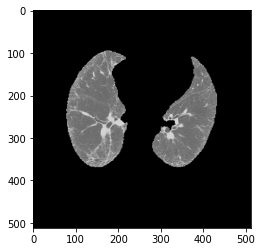

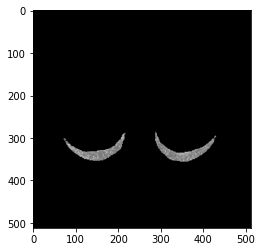

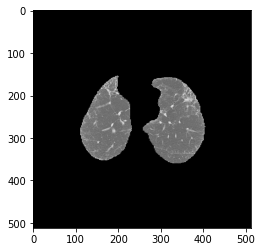

In [78]:
#Choosing Image for gradcam
image=my_imgarray_test[5]
a=np.expand_dims(image,axis=0)
plt.imshow(image[:,:,0],cmap='gray')
plt.show()
plt.imshow(image[:,:,1],cmap='gray')
plt.show()
plt.imshow(image[:,:,2],cmap='gray')
plt.show()

In [67]:
# Grad Cam to visualize where it is happening
img_size = (512, 512,3)
last_conv_layer_name = "conv2d_1"

In [68]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

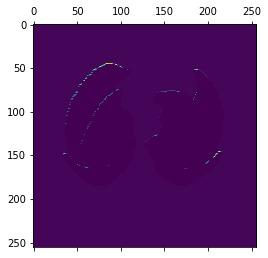

In [79]:
# Generate class activation heatmap
img_array=a
heatmap = make_gradcam_heatmap(img_array, model_Built, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


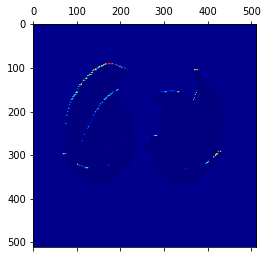

In [84]:
import matplotlib.cm as cm
def save_and_display_gradcam(image, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    
    img = keras.preprocessing.image.img_to_array(image[:,:,0])

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.matshow(superimposed_img)
    plt.show()



save_and_display_gradcam(image, heatmap,alpha=100)